In [265]:
#General
import json
import zipfile
import os
import subprocess
import math
import time
import progressbar
import pickle
import joblib
import s3fs
from pathlib import Path

#Math & Visualization
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
# get_ipython().run_line_magic('matplotlib', 'inline')
import seaborn as sns
sns.set()

# Oversampling
# from imblearn.over_sampling import SMOTE

## Metrics
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold , StratifiedKFold

## Models
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.utils import class_weight
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
# from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

import tensorflow as tf
# from tensorflow.keras.backend.tensorflow_backend import set_session
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Precision, Recall, PrecisionAtRecall
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Dense, Embedding, LSTM, GRU, Dropout, Flatten, Activation
from tensorflow.keras.callbacks import EarlyStopping,  ModelCheckpoint, CSVLogger, TensorBoard, ProgbarLogger
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import joblib
import copy
from tensorflow.keras.models import load_model

from data import readLocally
from visualization import plot_roc_auc, pr_curve, format_vertical_headers

In [266]:
X_train, y_train, X_test, y_test, X_val, y_val, labels_hash, scaler = readLocally()


columns=[
    "day", "age", "gender", "merchant", "category", "amount", 
    "curr_day_tr_n","ave_tr_p_day_amount", "tot_ave_tr_amount", "is_mer_new","com_tr_type", "com_mer",
#"fraud"
] 

format_vertical_headers(pd.DataFrame([
    scaler.data_min_,
    scaler.data_max_
], columns=columns, index=["MIN", "MAX"]))



_ _ _ _ _ _ _ _ _ _   READ DATA LOCALLY  _ _ _ _ _ _ _ _ _ _ 




SHAPES & KEYS:
    X_train          : (285428, 25, 12)   -> 48%
    y_train          : (285428,)
    X_test           : (237858, 25, 12)   -> 40%
    y_test           : (237858,)
    X_val            : (71357, 25, 12)   -> 12%
    y_val            : (71357,)
    ______________________
    Total Data Size  : 594643
    labels_hash Keys : dict_keys(['customer', 'age', 'gender', 'merchant', 'category'])
    
    TRAIN DATA
    ______________________
    Positives        : 3461   -> 1.21%
    Negatives        : 281967   -> 98.79%
    
    TEST DATA
    ______________________
    Positives        : 2839   -> 1.19%
    Negatives        : 235019   -> 98.81%   
    
    VAL DATA
    ______________________
    Positives        : 900   -> 1.26%
    Negatives        : 70457   -> 98.74%
    


,day,age,gender,merchant,category,amount,curr_day_tr_n,ave_tr_p_day_amount,tot_ave_tr_amount,is_mer_new,com_tr_type,com_mer
MIN,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
MAX,179,7,3,49,14,8329.96,5,6888.3,6888.3,1,14,49


In [267]:
format_vertical_headers(pd.DataFrame(X_val[0], columns=columns).head())

,day,age,gender,merchant,category,amount,curr_day_tr_n,ave_tr_p_day_amount,tot_ave_tr_amount,is_mer_new,com_tr_type,com_mer
0,0.394,0.625,0.5,0.38,0.867,0,0.333,0.004,0.004,0.5,0.867,0.62
1,0.4,0.625,0.5,0.38,0.867,0.006,0.333,0.004,0.004,0.5,0.867,0.62
2,0.406,0.625,0.5,0.92,0.267,0.002,0.333,0.004,0.004,0.5,0.867,0.62
3,0.411,0.625,0.5,0.38,0.867,0.006,0.333,0.004,0.004,0.5,0.867,0.62
4,0.417,0.625,0.5,0.64,0.2,0.009,0.333,0.004,0.004,1,0.867,0.62


In [268]:
format_vertical_headers(labels_hash["category"].head())

,Index,Label
0,12,'es_transportation'
12,4,'es_health'
40,9,'es_otherservices'
77,3,'es_food'
127,6,'es_hotelservices'


results/v7/ 

LAST MODEL


Model: "sequential_160"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_120 (GRU)                (None, 50)                9600      
_________________________________________________________________
dense_240 (Dense)            (None, 300)               15300     
_________________________________________________________________
activation_240 (Activation)  (None, 300)               0         
_________________________________________________________________
dense_241 (Dense)            (None, 300)               90300     
_________________________________________________________________
activation_241 (Activation)  (None, 300)               0         
_________________________________________________________________
dropout_80 (Dropout)         (None, 300)               0         
_________________________________________________________________
dense_242 (Dense)        

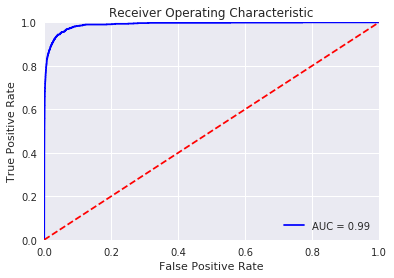

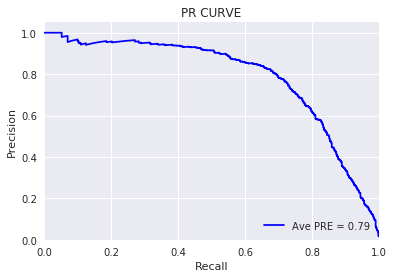

In [269]:
model_dir = "results/v7/"

print(model_dir, "\n\nLAST MODEL\n\n")
rnn = load_model(model_dir+"rnn_model.h5")
print(rnn.summary())

y_pred_val_1    = rnn.predict(X_val)

print("\n\nHISTORY BEST PARAMS\n\n")
history = joblib.load(model_dir+"rnn.history")
print(history["best_params_"])

print("\n\nCONFUSION MATRIX OVER VALIDATION DATA\n\n")
tn1, fp1, fn1, tp1 = confusion_matrix(
    y_val, y_pred_val_1.round()).ravel()
print_confusion_matrix(tn1, fp1, fn1, tp1)

print("\n\nPLOTS OVER VALIDATION DATA\n\n")
plot_roc_auc(y_val, y_pred_val_1)
pr_curve(y_val, y_pred_val_1)




CONFUSION MATRIX OVER TEST DATA



            PREDICTED CLASSES
            POSITIVE   | NEGATIVE
    _____________________________
    ACTUAL   |         |
    POSITIVE | TP: 1513   FN: 1326
    _____________________________
    ACTUAL   |         |
    NEGATIVE | FP: 173   TN: 234846
    


PLOTS OVER TEST DATA


ROC AUC:  0.99
PR-RC AUC:  0.77
average_precision:  0.77


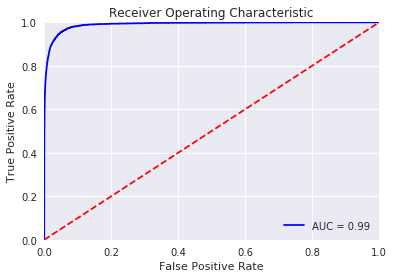

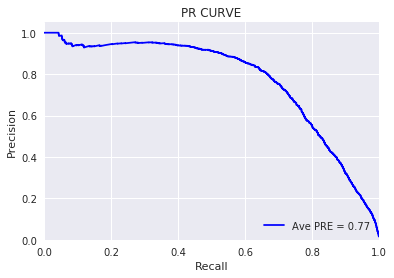

In [270]:
y_pred_test = rnn.predict(X_test)


print("\n\nCONFUSION MATRIX OVER TEST DATA\n\n")
tn2, fp2, fn2, tp2 = confusion_matrix(
    y_test, y_pred_test.round()).ravel()
print_confusion_matrix(tn2, fp2, fn2, tp2)

print("\n\nPLOTS OVER TEST DATA\n\n")
plot_roc_auc(y_test, y_pred_test)
pr_curve(y_test, y_pred_test)

SECOND LAST MODEL
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 50)                12600     
_________________________________________________________________
dense_15 (Dense)             (None, 200)               10200     
_________________________________________________________________
activation_15 (Activation)   (None, 200)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 200)               40200     
_________________________________________________________________
activation_16 (Activation)   (None, 200)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 

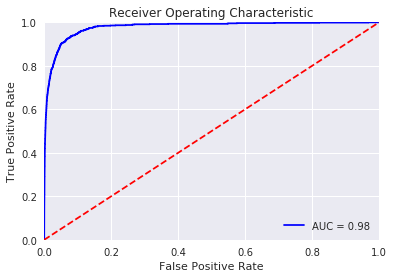

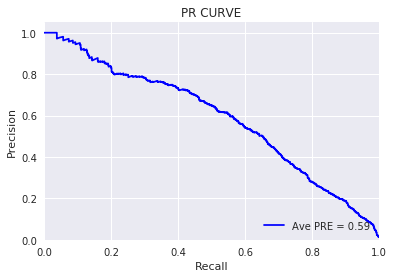

In [271]:
print("SECOND LAST MODEL")
second_last_rnn = load_model(model_dir+"checkpoint_model.h5")
print(second_last_rnn.summary(), "\n\n")
y_pred_val_3    = second_last_rnn.predict(X_val)

tn3, fp3, fn3, tp3 = confusion_matrix(
    y_val, y_pred_val_3.round()).ravel()
print_confusion_matrix(tn3, fp3, fn3, tp3)

plot_roc_auc(y_val, y_pred_val_3)
pr_curve(y_val, y_pred_val_3)

In [272]:
history.keys()

dict_keys(['scoring', 'n_jobs', 'iid', 'refit', 'cv', 'verbose', 'pre_dispatch', 'error_score', 'return_train_score', 'param_grid', 'multimetric_', 'best_index_', 'best_score_', 'best_params_', 'refit_time_', 'scorer_', 'cv_results_', 'n_splits_'])

In [273]:
important_cols = ["params", "mean_train_accuracy", "mean_train_precision", "mean_train_recall", "mean_train_roc_auc", "mean_test_accuracy", "mean_test_precision", "mean_test_recall",  "mean_test_roc_auc" ]
renamed_cols = ["params", "tr_acc", "tr_pre", "tr_rec", "tr_rocauc", "te_acc", "te_pre", "te_rec",  "te_rocauc" ]
cvResultsDf = pd.DataFrame(history["cv_results_"]).fillna(0).round(2) 
print("Best Model Index: ", history["best_index_"])


Best Model Index:  12


In [274]:
print("Best Model Train & Test Data")

bestModelDf = cvResultsDf[cvResultsDf["params"]== history["best_params_"]][important_cols].rename(columns=dict(zip(important_cols, np.array(renamed_cols).T)))
format_vertical_headers(bestModelDf)

Best Model Train & Test Data


,params,tr_acc,tr_pre,tr_rec,tr_rocauc,te_acc,te_pre,te_rec,te_rocauc
12,"{'dropout': True, 'dropout_rate': 0.2, 'epochs': 50, 'hidden_layer_activation': 'sigmoid', 'hidden_layers': 2, 'hidden_layers_neurons': 300, 'loss': 'binary_crossentropy', 'modelType': 'GRU', 'optimizer': 'adam', 'output_layer_activation': 'sigmoid', 'rnn_hidden_layers': 0, 'rnn_hidden_layers_neurons': 50, 'rnn_layer_activation': 'sigmoid'}",0.99,0.77,0.66,0.99,0.99,0.77,0.67,0.99


In [275]:
print("\n\n ALL MODELS \n\n")
format_vertical_headers(
    cvResultsDf[important_cols].rename(
        columns=dict(zip(important_cols, np.array(renamed_cols).T))
    ).sort_values(by='te_rec', ascending=False)
)



 ALL MODELS 




,params,tr_acc,tr_pre,tr_rec,tr_rocauc,te_acc,te_pre,te_rec,te_rocauc
12,"{'dropout': True, 'dropout_rate': 0.2, 'epochs': 50, 'hidden_layer_activation': 'sigmoid', 'hidden_layers': 2, 'hidden_layers_neurons': 300, 'loss': 'binary_crossentropy', 'modelType': 'GRU', 'optimizer': 'adam', 'output_layer_activation': 'sigmoid', 'rnn_hidden_layers': 0, 'rnn_hidden_layers_neurons': 50, 'rnn_layer_activation': 'sigmoid'}",0.99,0.77,0.66,0.99,0.99,0.77,0.67,0.99
5,"{'dropout': True, 'dropout_rate': 0.2, 'epochs': 50, 'hidden_layer_activation': 'sigmoid', 'hidden_layers': 2, 'hidden_layers_neurons': 200, 'loss': 'binary_crossentropy', 'modelType': 'GRU', 'optimizer': 'adam', 'output_layer_activation': 'sigmoid', 'rnn_hidden_layers': 0, 'rnn_hidden_layers_neurons': 100, 'rnn_layer_activation': 'sigmoid'}",0.99,0.81,0.63,0.99,0.99,0.81,0.63,0.99
13,"{'dropout': True, 'dropout_rate': 0.2, 'epochs': 50, 'hidden_layer_activation': 'sigmoid', 'hidden_layers': 2, 'hidden_layers_neurons': 300, 'loss': 'binary_crossentropy', 'modelType': 'GRU', 'optimizer': 'adam', 'output_layer_activation': 'sigmoid', 'rnn_hidden_layers': 0, 'rnn_hidden_layers_neurons': 100, 'rnn_layer_activation': 'sigmoid'}",0.99,0.87,0.59,0.99,0.99,0.87,0.59,0.99
1,"{'dropout': True, 'dropout_rate': 0.2, 'epochs': 50, 'hidden_layer_activation': 'sigmoid', 'hidden_layers': 2, 'hidden_layers_neurons': 200, 'loss': 'binary_crossentropy', 'modelType': 'LSTM', 'optimizer': 'adam', 'output_layer_activation': 'sigmoid', 'rnn_hidden_layers': 0, 'rnn_hidden_layers_neurons': 100, 'rnn_layer_activation': 'sigmoid'}",0.99,0.83,0.58,0.99,0.99,0.83,0.58,0.99
4,"{'dropout': True, 'dropout_rate': 0.2, 'epochs': 50, 'hidden_layer_activation': 'sigmoid', 'hidden_layers': 2, 'hidden_layers_neurons': 200, 'loss': 'binary_crossentropy', 'modelType': 'GRU', 'optimizer': 'adam', 'output_layer_activation': 'sigmoid', 'rnn_hidden_layers': 0, 'rnn_hidden_layers_neurons': 50, 'rnn_layer_activation': 'sigmoid'}",0.99,0.85,0.58,0.99,0.99,0.85,0.58,0.99
9,"{'dropout': True, 'dropout_rate': 0.2, 'epochs': 50, 'hidden_layer_activation': 'sigmoid', 'hidden_layers': 2, 'hidden_layers_neurons': 300, 'loss': 'binary_crossentropy', 'modelType': 'LSTM', 'optimizer': 'adam', 'output_layer_activation': 'sigmoid', 'rnn_hidden_layers': 0, 'rnn_hidden_layers_neurons': 100, 'rnn_layer_activation': 'sigmoid'}",0.99,0.82,0.58,0.99,0.99,0.81,0.58,0.99
0,"{'dropout': True, 'dropout_rate': 0.2, 'epochs': 50, 'hidden_layer_activation': 'sigmoid', 'hidden_layers': 2, 'hidden_layers_neurons': 200, 'loss': 'binary_crossentropy', 'modelType': 'LSTM', 'optimizer': 'adam', 'output_layer_activation': 'sigmoid', 'rnn_hidden_layers': 0, 'rnn_hidden_layers_neurons': 50, 'rnn_layer_activation': 'sigmoid'}",0.99,0.83,0.56,0.99,0.99,0.83,0.56,0.99
8,"{'dropout': True, 'dropout_rate': 0.2, 'epochs': 50, 'hidden_layer_activation': 'sigmoid', 'hidden_layers': 2, 'hidden_layers_neurons': 300, 'loss': 'binary_crossentropy', 'modelType': 'LSTM', 'optimizer': 'adam', 'output_layer_activation': 'sigmoid', 'rnn_hidden_layers': 0, 'rnn_hidden_layers_neurons': 50, 'rnn_layer_activation': 'sigmoid'}",0.99,0.84,0.53,0.99,0.99,0.84,0.53,0.99
2,"{'dropout': True, 'dropout_rate': 0.2, 'epochs': 50, 'hidden_layer_activation': 'sigmoid', 'hidden_layers': 2, 'hidden_layers_neurons': 200, 'loss': 'binary_crossentropy', 'modelType': 'LSTM', 'optimizer': 'adam', 'output_layer_activation': 'sigmoid', 'rnn_hidden_layers': 1, 'rnn_hidden_layers_neurons': 50, 'rnn_layer_activation': 'sigmoid'}",0,0,0,0,0,0,0,0
3,"{'dropout': True, 'dropout_rate': 0.2, 'epochs': 50, 'hidden_layer_activation': 'sigmoid', 'hidden_layers': 2, 'hidden_layers_neurons': 200, 'loss': 'binary_crossentropy', 'modelType': 'LSTM', 'optimizer': 'adam', 'output_layer_activation': 'sigmoid', 'rnn_hidden_layers': 1, 'rnn_hidden_layers_neurons': 100, 'rnn_layer_activation': 'sigmoid'}",0,0,0,0,0,0,0,0
